# A quick example of using MAPS to search with square-root spherical harmonics

Imports. While ligo.skymap isn't necessary, it does contain many useful plotting tools. If you do not want to use this, healpy has much of the same abilities.

In [2]:
import numpy as np, argparse, pickle
import healpy as hp
import os as oss
import numpy.random as nr

from maps import anis_pta as ap
from maps import utils
from enterprise.signals import anis_coefficients as ac

import matplotlib.pyplot as pl
import healpy as hp

# A helpful plotting tool
import ligo.skymap.plot

/Users/gersbaka/opt/anaconda3/envs/pta_software/lib/python3.9/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


## Generating data

For this test we will need to generate our own data. We skip many of the steps we might have to do with real data and instead assume that we have run through everything to the point of having pulsar correlations and pulsar correlation uncertainties.
- Note that while MAPS does support pair covariance, this example will not use it. To generate pair covariance matrices of you own, look into the optimal statistic code in [DEFIANT](https://github.com/GersbachKa/defiant).

For this example, we will generate 67 pulsars with random positions in the sky.

In [3]:
seed = 616 #choose a seed for random draws
rng = nr.default_rng(seed)

In [4]:
#Set configuration for square-root spherical harmonic search
lmax = 6 # The maximum l value to search in spherical harmonics
nside = 8 # Maximum nside for the healpy pixelization

n_psrs = 67 # The number of pulsars
n_cc = (n_psrs * (n_psrs-1))//2 # The number of pulsar pairs

print(f"Using {n_psrs} pulsars with {n_cc} pairs")

Using 67 pulsars with 2211 pairs


In [5]:
#Draw random uniform positions for pulsars in PTA
psrs_phi = rng.uniform(low = 0, high = 2 * np.pi, size = n_psrs)
psrs_theta = np.arccos(1 - 2 * rng.uniform(0, 1, size = n_psrs))

In [6]:
#Convert to RA/DEC for plotting
psrs_ra = psrs_phi
psrs_dec = np.pi / 2 - psrs_theta
rad_2_deg = 180 / np.pi

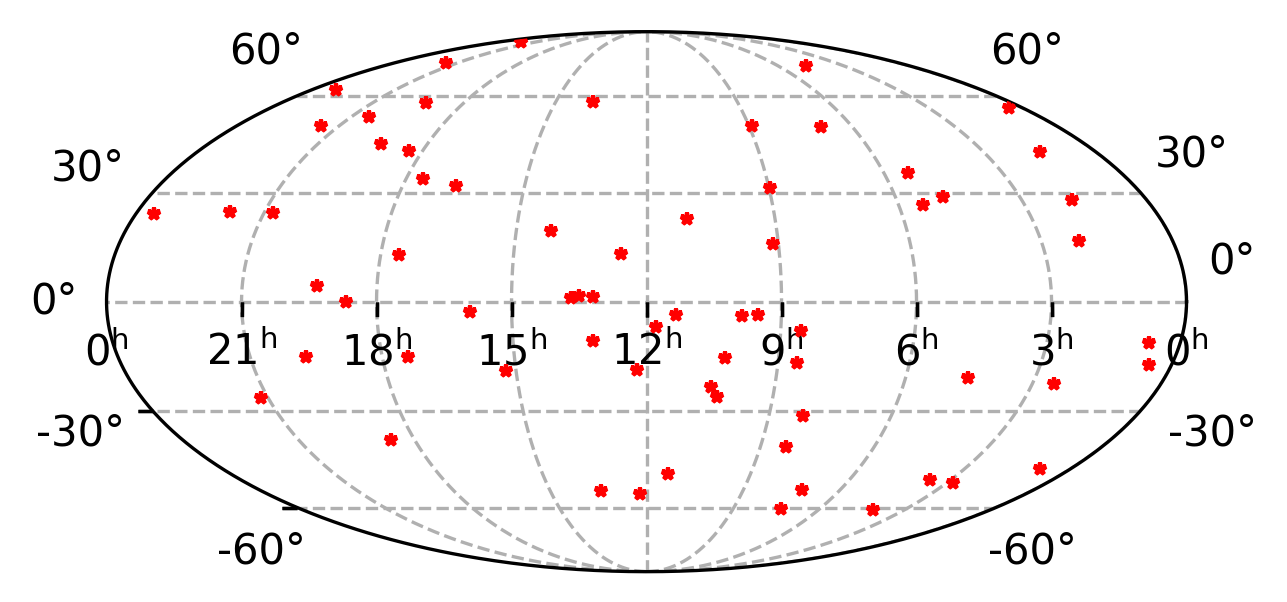

In [7]:
#Make figure here
fig = pl.figure(figsize=(4, 4), dpi=300)

ax = pl.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro hours mollweide')

ax.grid(linestyle='dashed',)

for jj in range(n_psrs):
    ax.plot(psrs_ra[jj] * rad_2_deg, psrs_dec[jj] * rad_2_deg, color = 'red', 
            transform=ax.get_transform('world'),
        marker = '*', markersize = 3, ls = '',)
    
pl.show()

### Creating the injection

For this test we will first generate an isotropic GWB, then add in a hotspot. We generate this as individual pixel powers. For an isotropic background, we can supply a pixel vector of all 1, meaning even power throughout the sky. On top of this, select a circular area on the sky at (lat = 45,long = 270) for which we increase the power.

In [8]:
#Simulate an isotropic background plus a hotspot
input_map = np.ones(hp.nside2npix(nside))

lon = 270
lat = 45
vec = hp.ang2vec(lon, lat, lonlat=True)

radius = np.radians(10)

disk_anis = hp.query_disc(nside = nside, vec = vec, radius = radius, inclusive = False)

input_map[disk_anis] += 50

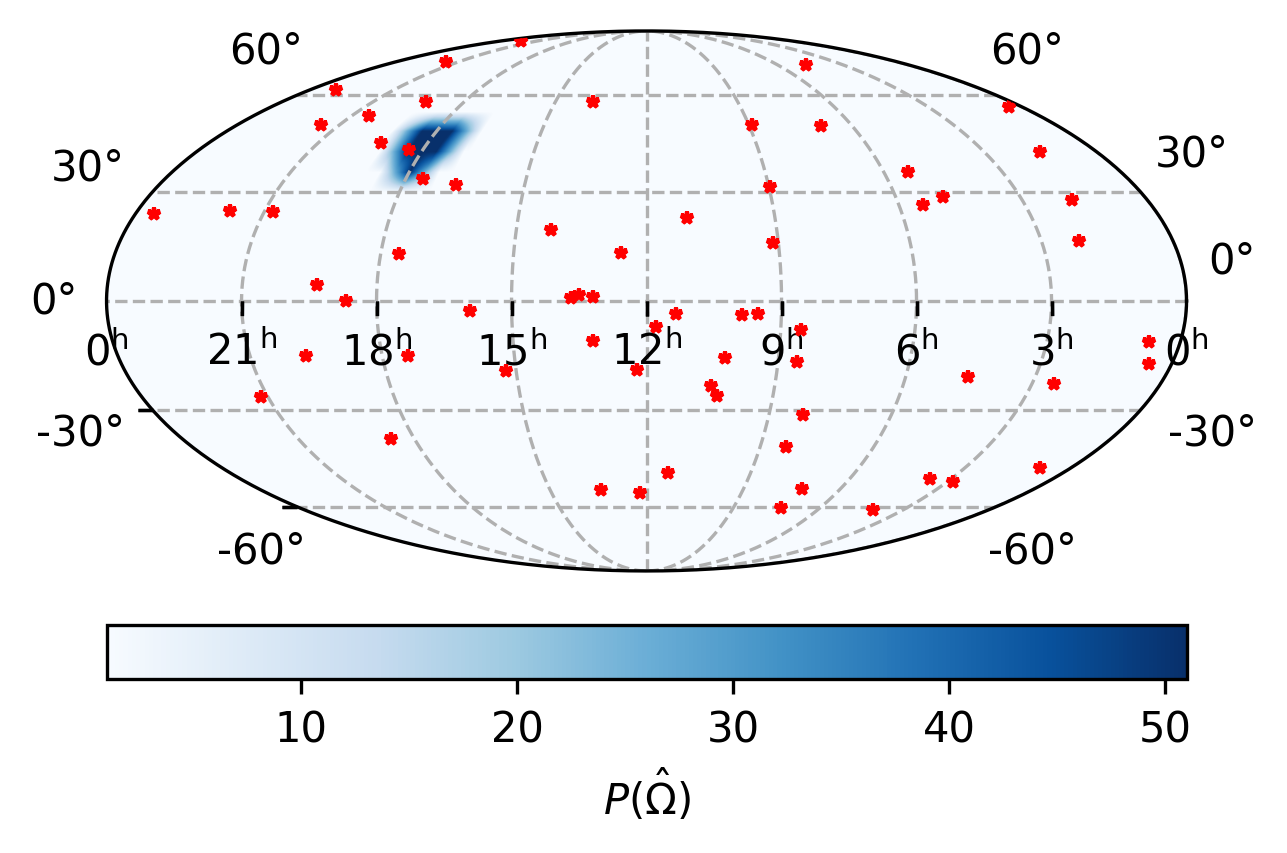

In [9]:
# Plot the injection
fig = pl.figure(figsize=(4, 4), dpi=300)

ax = pl.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro hours mollweide')

cax = ax.imshow_hpx(input_map, cmap='Blues',)#smooth=1.0*u.deg)
pl.colorbar(cax, orientation='horizontal',pad=0.05, label='$P(\hat\Omega)$')

ax.grid(linestyle='dashed',)

for jj in range(n_psrs):
    ax.plot(psrs_ra[jj] * rad_2_deg, psrs_dec[jj] * rad_2_deg, color = 'red', 
            transform=ax.get_transform('world'),
        marker = '*', markersize = 3, ls = '',)
    
pl.show()

### With our injection sorted, we now need to make data

Now that we have individual pixel powers, we can use a handy attribute from an anis_pta object.
The attribute in question, pta.F_mat, is the pixel basis design matrix for our correlations. What we can do with this is generate correlations from the product of this design matrix with the pixel power injection vector.

Note: We don't have to supply correlations upon creating an anis_pta object. If we choose not to, we can supply these after the fact with the pta.set_data(). 

In [10]:
#Initiate a PTA object without correlation values to gain access to some useful functions
pta = ap.anis_pta(psrs_theta, psrs_phi, nside = nside, l_max = lmax,
                  mode = 'sqrt_power_basis', include_pta_monopole = False)

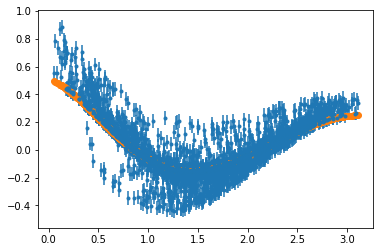

In [11]:
# Now create the simulated data from the basis function and the input map
synth_rho = pta.F_mat @ input_map #+ rng.normal(np.zeros(n_cc), syth_sig)
# While this simulation will not include noise, you could do so by adding a normal component
# with a standard deviation set by synth_sig.T


#Alternatively, you could simulate noisy correlations with mean given by HD curve, 
# and sigma by our choice above
#synth_rho = rng.normal(init_pta.get_pure_HD(), synth_sig) 


# Arbitrarily good choice for measurement uncertainty on the correlations
synth_sig = np.repeat(0.1, repeats = n_cc)


# Plot the data
pl.errorbar(pta.xi, synth_rho, yerr = synth_sig / 2, ls = '', marker = '.')
pl.plot(pta.xi, pta.get_pure_HD(), marker = 'o', ls = '')
pl.show()

## With our data generated, lets run the analysis

Our first step is to actually supply our anis_pta object with the data we generated

In [12]:
#Given our "PTA data", give the anis_pta object the correlations and their uncertainties
pta.set_data(synth_rho, synth_sig, 1)

To get the maximum likelihood square root power, we can use the pta.max_lkl_sqrt_power() function!
This function returns and lmfit minimizer object with the minimized solution contained within. This can be helpful in cases where you may need to do some post-processing

In [13]:
lm_out = pta.max_lkl_sqrt_power()
lm_out

In [14]:
#Extract best fit b_lm params as a numpy array
lm_params = np.array(list(lm_out.params.valuesdict().values()))
lm_params_err = np.array([param.stderr for param in list(lm_out.params.values())])


## Post processing

With our best-fit parameters found, lets first plot the recovered ORF

In [15]:
#Convert from the square-root spherical harmonic basis to spherical harmonic basis
lm_clm = utils.convert_blm_params_to_clm(pta, lm_params[1:])

#Calculate the angular power spectrum in the spherical harmonic basis
Cl = utils.angular_power_spectrum(lm_clm) 

#Calculate the best-fit ORF
orf = pta.orf_from_clm(np.append((lm_params[0]), lm_clm))
#orf = np.sum(lm_clm[:, np.newaxis] * pta.Gamma_lm, axis = 0) #Another way to get recovered ORF

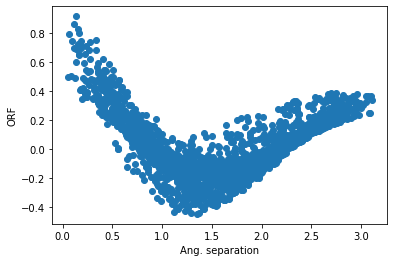

In [16]:
#Plot the best-fit correlations
pl.plot(pta.xi, orf, ls = '', marker = 'o')

pl.xlabel(r"Ang. separation")
pl.ylabel(r"ORF")

pl.show()

Next, lets compare our angular power spectrum recovery to what we injected

In [17]:
input_clm = ac.clmFromMap_fast(input_map, lmax = lmax)

input_Cl = utils.angular_power_spectrum(input_clm)

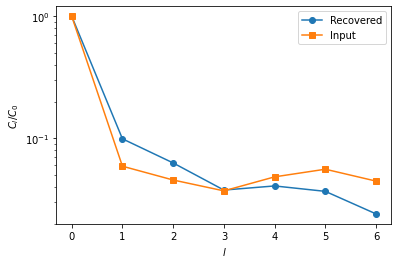

In [18]:
#Plot the angular power spectrum

pl.plot(range(pta.l_max + 1), Cl / Cl[0], marker = 'o', label = 'Recovered')
pl.plot(range(pta.l_max + 1), input_Cl / input_Cl[0], marker = 's', label = 'Input')

pl.xlabel(r"$l$")
pl.ylabel(r"$C_{l} / C_{0}$")
pl.yscale('log')
pl.legend()
pl.show()

Now look into the SNRs

In [19]:
#Calculate the total, isotropic, and anisotropic S/N values

total_sn2, iso_sn2, anis_sn2 = utils.signal_to_noise(pta)

# Notice that these values are squared SNRs! Keep that in mind!
total_sn = np.sqrt(total_sn2)
iso_sn = np.sqrt(iso_sn2)
anis_sn = np.sqrt(anis_sn2)

In [20]:
print('Total SNR:',total_sn, 'Isotropic SNR:', iso_sn, 'Anisotropic SNR:', anis_sn)

Total SNR: 96.24555083208149674 Isotropic SNR: 86.42891399037729794 Anisotropic SNR: 42.34676943303640803


Finally, lets plot the recovered pixel power map

In [21]:
#Translate the c_lm to a sky map
power = 10 ** lm_params[0] * ac.mapFromClm(lm_clm, nside = pta.nside) #Note we model the amplitude in log-space

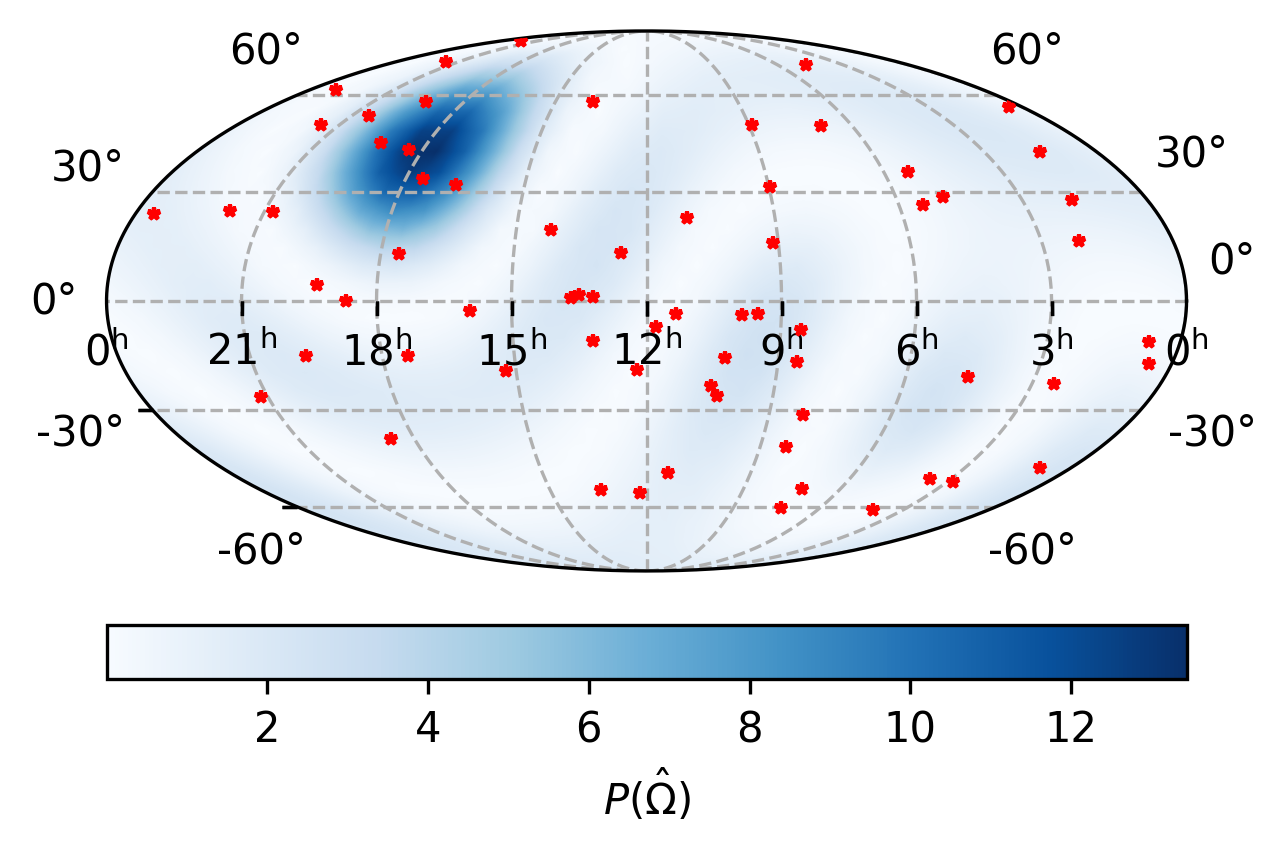

In [22]:
#Make sky map
fig = pl.figure(figsize=(4, 4), dpi=300)

ax = pl.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro hours mollweide')

ax.grid(linestyle='dashed',)

cax = ax.imshow_hpx(power, cmap='Blues',)#smooth=1.0*u.deg)
pl.colorbar(cax, orientation='horizontal',pad=0.05, label='$P(\hat\Omega)$')

#Plot the puslars
for jj in range(n_psrs):
    ax.plot(psrs_ra[jj] * rad_2_deg, psrs_dec[jj] * rad_2_deg, color = 'red', 
            transform=ax.get_transform('world'),
        marker = '*', markersize = 3, ls = '',)
    
pl.show()